**Sentimental analysis Kaggle**

Public leaderboard (AUC-ROC) : 0.99221

In [0]:
!pip install tensorflow-gpu 

In [0]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "tselischevivaniad5" # username from the json file
os.environ['KAGGLE_KEY'] = "eae1e975388931d59f1699ea0057a26c" # key from the json file

**Загрузки данных**

In [0]:
!kaggle competitions download -c iad-deep-learning-sentiment

 76% 52.0M/68.0M [00:00<00:00, 100MB/s] 
100% 68.0M/68.0M [00:00<00:00, 153MB/s]
  0% 0.00/2.08M [00:00<?, ?B/s]
100% 2.08M/2.08M [00:00<00:00, 138MB/s]
 97% 576M/595M [00:03<00:00, 218MB/s]
100% 595M/595M [00:03<00:00, 182MB/s]
  0% 0.00/8.37M [00:00<?, ?B/s]
100% 8.37M/8.37M [00:00<00:00, 76.9MB/s]


In [0]:
!unzip \*.zip

Archive:  y_train.csv.zip
  inflating: y_train.csv             

Archive:  x_test.txt.zip
  inflating: x_test.txt              

Archive:  random_prediction.csv.zip
  inflating: random_prediction.csv   

Archive:  x_train.txt.zip
  inflating: x_train.txt             

4 archives were successfully processed.


In [0]:
x_train = pd.read_csv('./x_train.txt', sep="\r\t", header=None)
x_test = pd.read_csv('./x_test.txt', sep="\r\t", header=None)
y_train = pd.read_csv('./y_train.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [0]:
x_train.shape

(3600000, 1)

In [0]:
y_train.shape

(3600000, 2)

In [0]:
x_train.head()

,0
0,Stuning even for the non-gamer: This sound tra...
1,The best soundtrack ever to anything.: I'm rea...
2,Amazing!: This soundtrack is my favorite music...
3,Excellent Soundtrack: I truly like this soundt...
4,"Remember, Pull Your Jaw Off The Floor After He..."


In [0]:
x_test.head()

,0
0,Great CD: My lovely Pat has one of the GREAT v...
1,One of the best game music soundtracks - for a...
2,Batteries died within a year ...: I bought thi...
3,"works fine, but Maha Energy is better: Check o..."
4,Great for the non-audiophile: Reviewed quite a...


In [0]:
y_train.head()

,Id,Probability
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0


In [0]:
print('Кол-во пропущенных значений в train: ', np.sum(x_train[0].isnull()))
print('Кол-во пропущенных значений в test: ', np.sum(x_test[0].isnull()))

Кол-во пропущенных значений в train:  0
Кол-во пропущенных значений в test:  0


In [0]:
type(y_train['Probability'][0])

numpy.float64

**Preprocessing**

In [0]:
%%time 
#word count
x_train['count_word']=x_train[0].apply(lambda x: len(str(x).split()))
#Unique word count
x_train['count_unique_word']=x_train[0].apply(lambda x: len(set(str(x).split())))
#Word count percent in each comment:
x_train['word_unique_percent']=x_train['count_unique_word']*100/x_train['count_word']
#derived features

CPU times: user 49.1 s, sys: 32.8 ms, total: 49.1 s
Wall time: 49.1 s


In [0]:
np.max(x_train['count_word'])

257

In [0]:
import string

In [0]:
y_train = np.asarray(y_train['Probability'])

In [0]:
def delete_punctuation(x):
    punctuation = list(string.punctuation)
    return ''.join([a if a not in punctuation + ['\n'] else ' ' for a in x])

In [0]:
x_train[0] = x_train[0].apply(lambda x: x.lower())
x_test[0] = x_test[0].apply(lambda x: x.lower())
# удаление пунктуации
x_train[0] = x_train[0].apply(delete_punctuation)
x_test[0] = x_test[0].apply(delete_punctuation)

In [0]:
x_train.head(5)

,0,count_word,count_unique_word,word_unique_percent
0,stuning even for the non gamer this sound tra...,80,61,76.250000
1,the best soundtrack ever to anything i m rea...,97,73,75.257732
2,amazing this soundtrack is my favorite music...,129,101,78.294574
3,excellent soundtrack i truly like this soundt...,118,87,73.728814
4,remember pull your jaw off the floor after he...,87,71,81.609195


In [0]:
y_train

array([1., 1., 1., ..., 0., 0., 1.])

In [0]:
from tqdm import tqdm_notebook

In [0]:
embed_size = 300 # how big is each word vector
max_features = 100000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a comment to use

list_sentences_train = x_train[0].values
list_sentences_test = x_test[0].values

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip

--2019-12-21 11:00:54--  http://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip [following]
--2019-12-21 11:00:54--  https://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.42B.300d.zip [following]
--2019-12-21 11:00:54--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [0]:
import zipfile
file_name = os.path.abspath('./glove.42B.300d.zip') # get full path of files
zip_ref = zipfile.ZipFile(file_name) # create zipfile object
zip_ref.extractall('./') # extract file to dir
zip_ref.close() # close file
os.remove(file_name) # delete zipped file

In [0]:
f = open('./glove.42B.300d.txt')
embeddings_index = dict() 
for line in tqdm_notebook(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
emb_mean, emb_std

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.005720101, 0.2951066)

In [0]:
word_index = tokenizer.word_index
unknown_words = set()
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    else: unknown_words.add(word)

**Модель и обучение**

In [0]:
def make_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(max_features, embed_size, input_length=maxlen, weights=[embedding_matrix], trainable = False))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False)))
  model.add(tf.keras.layers.Dense(64, activation="relu"))
  model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
  return model

In [0]:
model = make_model()
model.summary()
model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(clipvalue=1, clipnorm=1),
                  metrics=['accuracy'])
def schedule(ind):
    a = [0.001, 0.001, 0.0001, 0.0001, 0.00001, 0.00001, 0.000001]
    return a[ind]

lr = tf.keras.callbacks.LearningRateScheduler(schedule)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                           patience=4,
                           verbose=1,
                           min_delta=1e-4)

model.fit(x_train_pad, y_train, batch_size=128, epochs = 4, 
                    validation_split = 0.2, verbose = 1, callbacks = [lr])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 300)          30000000  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200, 256)          439296    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 30,850,049
Trainable params: 850,049
Non-trainable params: 30,000,000
____________________________________

**AUC-ROC для данных из трейна (просто посмотреть)**

In [0]:
y_predtr = model.predict(x_train_pad[3500000:])
y_predtr.shape

(100000, 1)

In [0]:
y_predtr[:10]

array([[1.7660856e-04],
       [7.1662664e-04],
       [1.3783574e-04],
       [2.1501780e-03],
       [9.6912509e-01],
       [7.0574880e-04],
       [6.1899424e-05],
       [3.6185980e-04],
       [2.9515725e-01],
       [1.8778443e-04]], dtype=float32)

In [0]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr , tpr , thresholds = roc_curve(y_train[3500000:], y_predtr)

In [0]:
import matplotlib.pyplot as plt

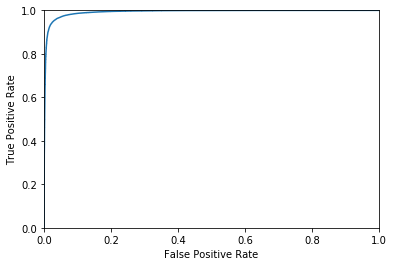

In [0]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 

In [0]:
auc_score=roc_auc_score(y_train[3500000:], y_predtr)
print(auc_score)

0.9923542781281447


**Предсказание и сабмит**

In [0]:
x_test_pad.shape

(400000, 200)

In [0]:
csv = pd.read_csv('./random_prediction.csv')

In [0]:
csv.head()

,Id,Probability
0,1,0.24916
1,2,0.47618
2,3,0.26317
3,4,0.29403
4,5,0.49895


In [0]:
y_pred = model.predict(x_test_pad)
y_pred.shape

(400000, 1)

In [0]:
csv['Probability'] = y_pred

In [0]:
csv.head()

,Id,Probability
0,1,0.996069
1,2,0.998689
2,3,0.001059
3,4,0.432619
4,5,0.997612


In [0]:
csv.to_csv("submission.csv", index=False)

In [0]:
!kaggle competitions submit -c iad-deep-learning-sentiment -f submission.csv -m "Submission1"

100% 6.95M/6.95M [00:00<00:00, 17.5MB/s]
Successfully submitted to Sentiment analysis